# PID Controller
*Topics: Math*

*Background required: H2 Math*

This is especially useful for any aspiring quantum engineer.

## Abstract

There are systems that are sensitive to disturbances from the environment, and so require constant correction. One way to apply this control effectively is using a PID controller, to minimise the disturbance to the system.

In this example, we learn how to program and tune a PID controller that moderates the temperature of an object.

## Background Infomation


In quantum systems, we typically need to implement some form of careful control over our system in order to account for errors introduced by noise in the surrounding environment. 

We usually have a designated *set-point* which we want to return the state of our system to as quickly as possible. This is typically very challenging, as the external noise of the environment is usually non-periodic, and the physical set-up we use typically has some response time to implement changes.

One example is temperature control of a laser to prevent frequency hopping due to changes in temperature of the gain medium. Steady lasers are especially important in many quantum applications, from optical tweezers, to interrogation lasers of quantum clocks.

Temperature fluctuations can be periodic (blackbody radiation) or non-periodic (someone touched the set-up, or the air-conditioning was changed). The control over temperature is typically done using a heating element (Peltier heat pump) which can both add and remove heat. It usually takes some time to heat up (cool down) and for the heat to spread across the gain medium. As such, control theory is needed to minimise the disturbance to the system.

PID controllers have three components (1) proportional control, (2) integral control, and (3) derivative control. They apply the changes as follows

* Proportional: The bigger the error, the stronger the control signal
* Integral: The longer the error, the stronger the control signal
* Derivative: The faster the error is reduced, the weaker the control signal

Together, they define a control system that is versatile for use in many set-ups.

## Theory

As mentioned earlier, we typically have a set value we want our system to stay at. For now, we will assume a constant set-point $s$.

We will have some *process variable* $y(t)$, which is the measured variable (temperature of the system), which will change with time. 

We can then define the *error variable* $e(t)$ of the system, given by the offset of the system from the set-point (desired temperature - current temperature).

$$
e(t)\equiv s - y(t)
$$



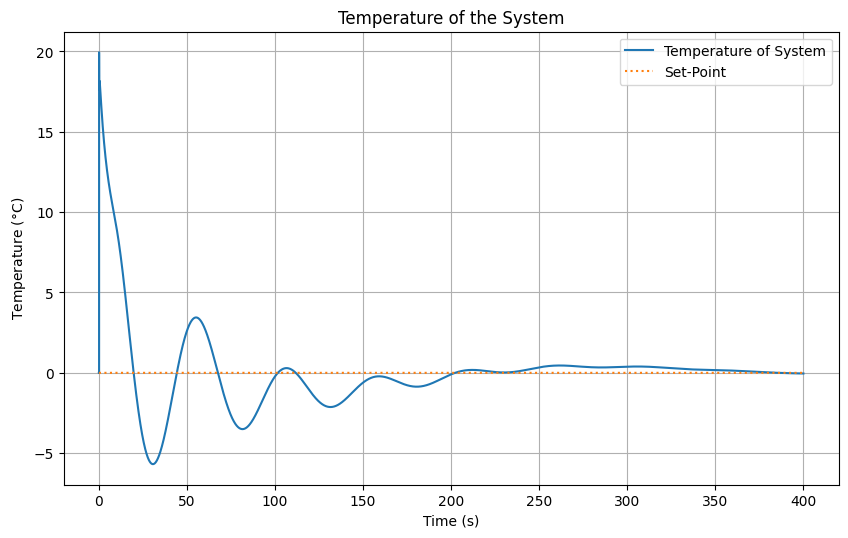

The controller then attempts to minimise the error over time, by introducing a control term to the system, $u(t)$ (apply heat/coldness to system). This control term is composed of three terms: Proportional, Integral, and Derivative



1.   Proportional Term (P)

    *   Used to drive the system back to the set-point
    *   As named, it is proportional to the error between the current state of the system and its set-point

    $$
    P = K_P \cdot e(t)
    $$

    *   Where $K_P$ is a tunable constant

2.   Integral Term (I)

    *   Accounts for the past history of the system
    *   Used to account for any remnant error after the application of the proportional term.
    *   Without this term, the system will take an large amount of time to reach the set-point

    $$
    I = K_I\cdot \int^{t}_{\tau = 0} e(\tau)\ d\tau
    $$

    *   Where $K_I$ is a tunable constant

3.   Derivative Term (D)

    *   Is used to predict the future state of the system
    *   Can be thought of as preventing overshooting of the system past the set-point.

    $$
    D = K_D \cdot \frac{d}{dt} e(t)
    $$

    *   Where $K_I$ is a tunable constant

Which gives us our overall control function when summed up

$$
u(t) = K_P\cdot e(t) + K_I\cdot \int^{t}_{\tau = 0} e(\tau)\ d\tau + K_D \cdot \frac{d}{dt} e(t)
$$

The three constants are typically determined by-hand, manually tuning, or using the [Ziegler-Nichols method](https://en.wikipedia.org/wiki/PID_controller#Ziegler%E2%80%93Nichols_method).

## Numerical Integration and Differentiation

Typically, we do not have an analytical form for our variables. We end up measuring the values of the variable at each point in time, in discrete steps. As such, we will have to perform integration and differentiation numerically rather than analytically.

Consider a series of points in time, with small time step $\delta t$. We can then perform differentation by simply finding the gradient at the last two points in time:

$$
\frac{d}{dt} e(t) \approx \frac{e(t) - e(t - \delta t)}{\delta t}
$$

For integration, we will have to perform a Riemann sum. This is essentially splitting the curve into rectangles of width $\delta t$ and height $e(t_i)$, and summing over their areas. $t_i$ is the instant in time we sum over.

$$
\int^t_{\tau = 0} e(\tau)\ d\tau \approx \sum_{t_i=0}^{t/\delta t} e(t_i)\cdot\delta t
$$

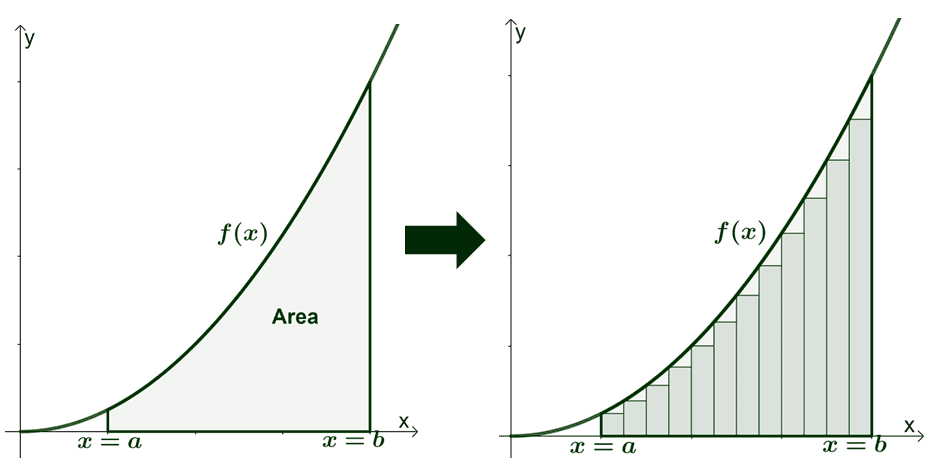

# Advance Integration methods 
Mathematically, the numerical integral between two points can be taken in 

## Simulation


### Libraries

To run the simulation, we need to first import the required libraries. We will need *matplotlb.pyplot* for plotting, and *numpy* for math.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

### Variables

Next, consider what variables we need for our simulation. We will need to define the set-point $s$, the three constants $K_P, K_I, K_D$.

For now, we will define them as follows:

In [ ]:
s = 0

K_P = 6     # 2.58
K_I = .2    # 0.058
K_D = 350   # 2.87

*You are welcome to tune them to see the effects on the system*

We will also need a variable to hold the current state of the system, or the process variable $y$. We will use a list, in order to have a record of the past values it takes on. 

We give it an initial value of $0$. To obtain the latest value of the process variable, we simple take the last item of the list, *y[-1]*.

In [ ]:
y = [0]

Finally, we need to define our small time step $\delta t$, as well as the total runtime of our simulation, and a list to hold the history of time steps.

The time step defines how often the PID controller will check the process variable, as well as the numerical time step.

In [ ]:
delta_t = 0.01
runtime = 400

time_hist = [0]

### System

We will create a model system to test our PID controller on. It will introduce the external noise to the system, in order to create a realistic scenario.

You may take this system as given, although you are welcome to add changes to it in order to test out the response of the controller.

In [ ]:
# This system is a cylinder, with a heat sensor at one end and a heat control at the other #
bg_temp = s + 2                                 # Background temperature

class part:
    def __init__(self):
        self.Temp = np.linspace(0,0,100)
        # Assuming a linear rod, with the heat control and heat sensor at either ends
        # This breaks down the rod into 100 distinct parts with different temperatures
    
    def apply(self,control):
        Temp_of_obj = self.Temp                 # Assuming a rod of 100 pieces
        k = 30                                  # Conductivity of rod
        temp_grad = list()                      # Finding temperature gradient down the rod
                                                # Which will determine response time of the system

        # To compute the heat flow, which is the temp gradient * conductivity * -1 #
        # We iterate down the different segments of the rod
        for i in range(Temp_of_obj.size):
            # Temperatures of (i) previous, (ii) current, (iii) next segment of the rod
            prev = Temp_of_obj[i - 1] if i != 0 else control                 
            curr = Temp_of_obj[i]
            next = Temp_of_obj[i + 1] if i != Temp_of_obj.size - 1 else y[-1]

            temp_grad += [prev + next - curr*2]                     # Temp gradient based on surrounding parts
                                                                    # For those who are familiar, its the second differential
        
        # Adding thermal fluctuations
        stochastic = np.random.uniform(-1,1,100)                    # Stochastic noise (Not used)
        forced = 0 if not (time_hist[-1] >= 0.1 and time_hist[-2] < 0.1) else 50/np.sqrt(2*np.pi) * np.exp(-(np.linspace(-10,0,100)/2)**2)
                                                                    # Adding a Gaussian heat spike at time t = 0.1
                                                                    # Models a clown touching your equipment using a molotov cocktail

        # Thermal loss to surroundings
        # Assumes a constant heat loss down the rod
        loss = (Temp_of_obj - bg_temp)*0.01
                # Background temp of s + 2

        # Finding the new temperature of the rod at the next step in time
        new_temp = k * np.array(temp_grad) * delta_t + Temp_of_obj + forced - loss*delta_t
                # New Temp = 
                # Heat flow from other segments 
                # + Original Temp 
                # + The Clown touching your equipment 
                # - Heat loss from sides of material
                
        self.Temp = new_temp

        y.append(Temp_of_obj[-1])

        #plt.plot(new_temp)
        #plt.show()

system = part()

### PID Function

Let's create a function to implement the PID control. It will take in the set point, as well as the history of the state of the system (including the current state). It will return the control value for this particular instant in time.


In [ ]:
def PID(set, hist):
    error = set - np.array(hist)                        # Offset of process variable from the set-point

    P = K_P * error[-1]                                 # PID terms
    I = K_I * np.sum(error*delta_t)
    D = 0
    
    if len(hist) > 1:
        D = K_D * (error[-1] - error[-2]) / delta_t     # Computes the differential term only if there is more than one point

    return P + I + D

### Running the Simulation

The best way to run the simulation is to use a while loop, which iterates until the total time ran exceeds the runtime defined earlier

In [ ]:
while time_hist[-1] < runtime:                      # While the time is less than the run time
    time_hist.append(time_hist[-1] + delta_t)       # Update the current time

    control = PID(s, y)                             # Find the control variable
    system.apply(control)                           # Apply it to our system, which modifies the temperature and returns the reading of its value

We can then plot our results.

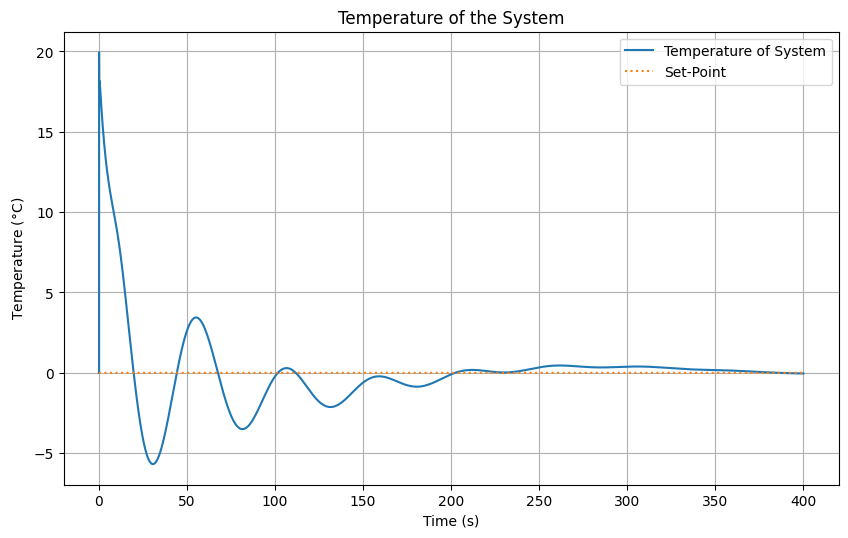

In [ ]:
plt.figure(figsize = (10,6), dpi = 100)                             # Changes the resolution of our graph

plt.plot(time_hist, y, label = "Temperature of System")             # Plots the changes in the temperature of the system
plt.plot(time_hist, [s]*len(time_hist), ':' ,label = "Set-Point")   # Plots the set-point
plt.title("Temperature of the System")                              # Adds a header title
plt.xlabel("Time (s)")                                              # Labels the x-axis
plt.ylabel("Temperature ($\degree$C)")                              # Labels the y-axis ($ is used to demarcate math mode printing)
plt.grid()                                                          # Turns on the background grid
plt.legend()                                                        # Turns on the legend

plt.show()                                                          # Prints the figure

## Example of Tuning

For a heat spike of $20°$C at time $t=0.1$s, we get the heat curve shown below. Note that the set-point is at $0°$C and the background temperature is at $2°$C.

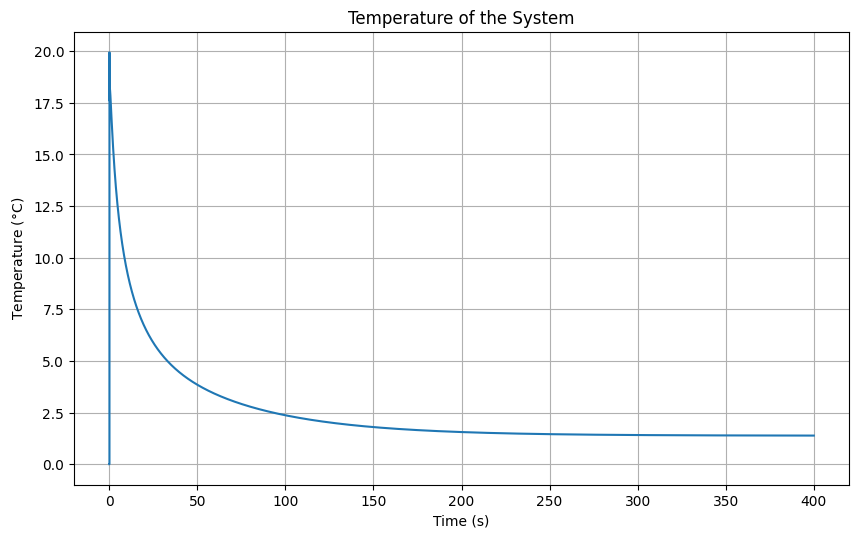

Using the Ziegler-Nichols method, we first need to find a $K_P$ where it wobbles. We set $K_P = 10$, and we find that the maximum gain is $K_u\approx4.3°$C and period $T_u\approx88.9$s. 

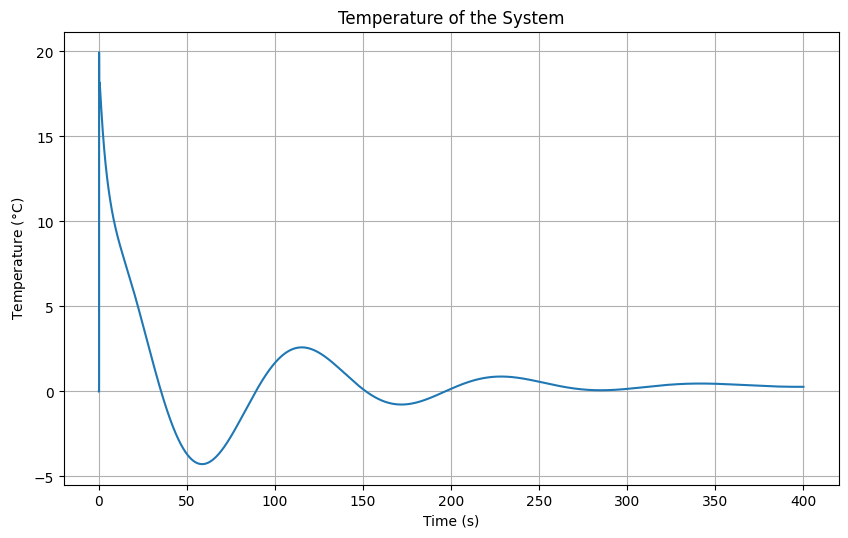

Thus, we can tune the other variables according to:

$$
K_P = 0.60 \cdot K_U,\\
K_I = 1.2 K_u/T_u,\\
K_D = 3K_uT_u/40
$$

to get

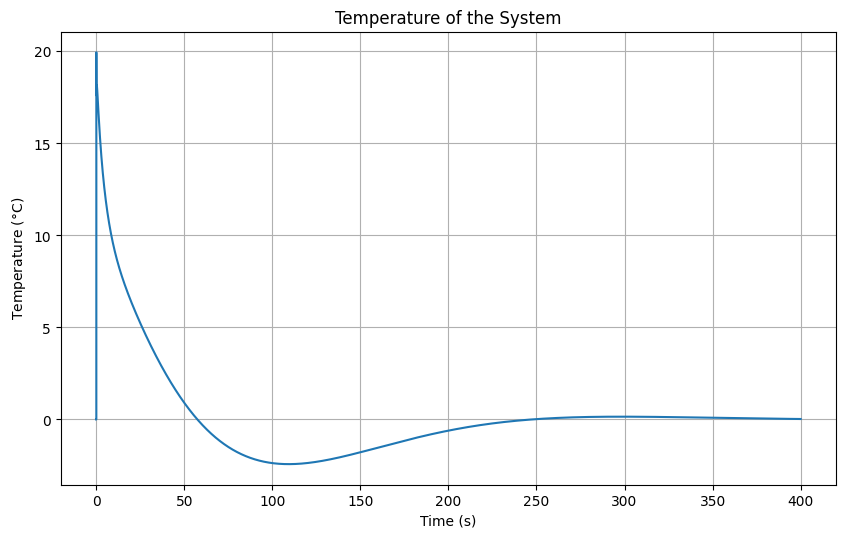

Which converges in about $5$ minutes. This is not surprising, given the conductivity and ambient heat loss of the system implemented on.

## Possible Extensions

*    Map out the effects of changing one of the variables
*    Consider a changing set-point, and its effects on a tuned system
*    What about a periodic drive disturbing the system?
*    How does the disturbance impulse (time taken to disturb the system) affect a tuned system
*    Is there a maximum amplitude of disturbance that the system cannot recover from?
*    The numerical integration is done by slicing into rectangles. What about using trapezoids or other integration techniques?
*    The numerical differentiation can be done by averaging the gradient over more points. How will this affect the PID control?
*    What about an additional term that includes the second derivative? How would it change the system?